# Representing an Artificial Neural Network as a Cartesian Genetic Program
(a.k.a dCGPANN)

Neural networks (deep, shallow, convolutional or not) are, after all, computer programs and as such can be encoded in a chromosome and represented as a Genetic Program. A dCGPANN, coded in the class *expression_ann_double*, is exactly this: a feed forward neural network represented into a chromosome using a Cartesian Genetic Programming encoding. Derivatives with respect to weights and biases can be easily extracted, the underlying algorithm being backward automated differentiation. Unlike other dCGP expression higher order derivatives are not available (no *gduals*). 

In [1]:
# Initial import
import dcgpy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle

%matplotlib inline

### Data set

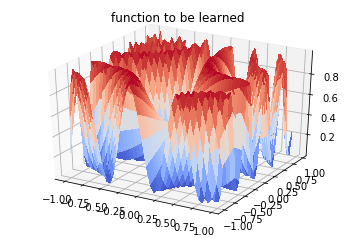

In [3]:
# To plot the unction we use a uniform grid
X = np.arange(-1, 1, 0.05)
Y = np.arange(-1, 1, 0.05)
n_samples = len(X) * len(Y)
points = np.zeros((n_samples, 2))

i=0
for x in X:
    for y in Y:
        points[i][0] = x
        points[i][1] = y
        i=i+1
labels = (np.sin(5 * points[:,0] * (3 * points[:,1] + 1.)) + 1. ) / 2.
points = points.reshape((n_samples,2))
labels = labels.reshape((n_samples,1))

# To plot the function 
X, Y = np.meshgrid(X, Y)
Z = (np.sin(5 * X * (3 * Y + 1.)) + 1. ) / 2.
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# We shuffle the points and labels
points, labels = shuffle(points, labels, random_state=0)
# We creat training and test sets
X_train = points[:800]
Y_train = labels[:800]
X_test = points[800:]
Y_test = labels[800:]
_ = plt.title("function to be learned")

### Mutating a dCGPANN

Starting error: 0.3671664831482467
Net complexity (number of active weights): 1120
Net complexity (number of unique active weights): 1120
Net complexity (number of active nodes): 73


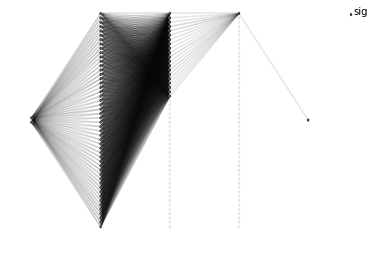

In [85]:
# Non linearities
# We define a single input single output dCGPANN.
dcgpann = dcgpy.encode_ffnn(2,1,[50,20],["sig", "sig", "sig"], 5)

# By default all weights (and biases) are set to 1 (and 0). We initialize them randomly
dcgpann.randomise_weights(mean = 0., std = 2.)
dcgpann.randomise_biases(mean = 0., std = 1.)

print("Starting error:", dcgpann.loss(points,labels, "MSE"))
print("Net complexity (number of active weights):", dcgpann.n_active_weights())
print("Net complexity (number of unique active weights):", dcgpann.n_active_weights(unique=True))
print("Net complexity (number of active nodes):", len(dcgpann.get_active_nodes()))
x = dcgpann.get()
w = dcgpann.get_weights()
b = dcgpann.get_biases()
res = []
dcgpann.visualize(show_nonlinearities=True)

100%|██████████| 100/100 [00:00<00:00, 220.29it/s]


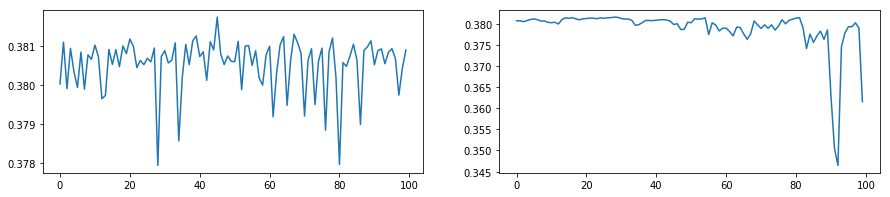

In [84]:
# We show the effect of mutations
n_mutations = 100
mut = []
for i in tqdm(range(n_mutations)):
    dcgpann.set(x)
    dcgpann.set_weights(w)
    dcgpann.set_biases(b)
    dcgpann.mutate_active_cgene(10)
    dcgpann.set_output_f(0)
    mut.append(dcgpann.loss(X_train,Y_train, "MSE"))
    
mut2 = []
dcgpann.set(x)
dcgpann.set_weights(w)
dcgpann.set_biases(b)
for i in tqdm(range(n_mutations)):
    dcgpann.mutate_active_cgene(10)
    dcgpann.set_output_f(0)
    mut2.append(dcgpann.loss(X_train,Y_train, "MSE"))

#plot
f, ax = plt.subplots(1,2, figsize=(15,3))
plt.subplot(1,2,1)
_ = plt.plot(mut)
plt.subplot(1,2,2)
_ = plt.plot(mut2)


In [86]:
lr0 = 0.3
for i in tqdm(range(5000)):
    lr = lr0 #* np.exp(-0.0001 * i)
    dcgpann.sgd(X_train, Y_train, lr, 32, "MSE")
    res.append(dcgpann.loss(X_train,Y_train, "MSE"))

100%|██████████| 5000/5000 [01:08<00:00, 72.92it/s]


RMSE:  0.11909962136298087
MSE:  0.01418471980880541


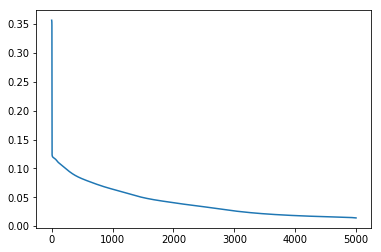

In [90]:
plt.plot(res)
print("RMSE: ", np.sqrt(res[-1]))
print("MSE: ", res[-1])

In [61]:
# We train
n_epochs = 200
print("Start error:", dcgpann.loss(X_train,Y_train, "MSE"), flush=True)

for i in tqdm(range(n_epochs)):
    dcgpann.sgd(X_train, Y_train, 0.3, 32, "MSE")

print("Current error:", dcgpann.loss(X_train,Y_train, "MSE"), flush=True)

xt = dcgpann.get()
wt = dcgpann.get_weights()
bt = dcgpann.get_biases()


Start error: 0.019283901151253245


100%|██████████| 200/200 [00:01<00:00, 114.40it/s]

Current error: 0.019031351430123515


100%|██████████| 100/100 [00:01<00:00, 93.76it/s]


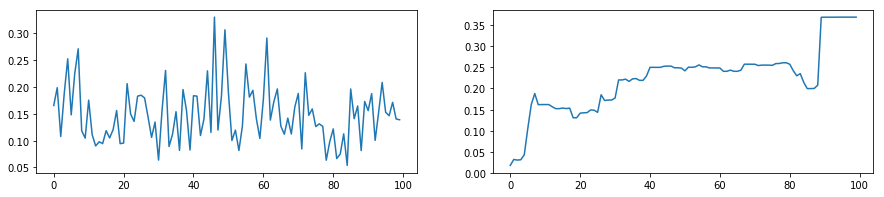

In [62]:
# We show the effect of mutations
n_mutations = 100
mut = []
for i in tqdm(range(n_mutations)):
    dcgpann.set(xt)
    dcgpann.set_weights(wt)
    dcgpann.set_biases(bt)
    dcgpann.mutate_active_cgene(10)
    dcgpann.set_output_f(0)
    mut.append(dcgpann.loss(points,labels, "MSE"))
    
mut2 = []
dcgpann.set(xt)
dcgpann.set_weights(wt)
dcgpann.set_biases(bt)
for i in tqdm(range(n_mutations)):
    dcgpann.mutate_active_cgene(1)
    dcgpann.set_output_f(0)
    mut2.append(dcgpann.loss(points,labels, "MSE"))

#plot
f, ax = plt.subplots(1,2, figsize=(15,3))
plt.subplot(1,2,1)
_ = plt.plot(mut)
plt.subplot(1,2,2)
_ = plt.plot(mut2)


100%|██████████| 10/10 [01:33<00:00,  9.33s/it]


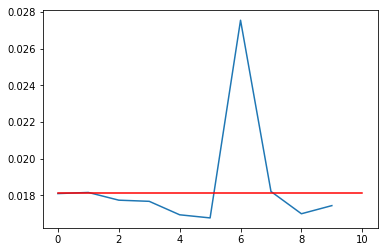

In [64]:
# We show the effect of trained mutations
n_mutations = 10
mut = []
for i in tqdm(range(n_mutations)):
    dcgpann.set(xt)
    dcgpann.set_weights(wt)
    dcgpann.set_biases(bt)
    dcgpann.mutate_active_cgene(10)
    dcgpann.set_output_f(0)
    for i in range(1000):
        dcgpann.sgd(X_train, Y_train, 0.3, 32, "MSE")
    mut.append(dcgpann.loss(X_train,Y_train, "MSE"))

dcgpann.set(xt)
dcgpann.set_weights(wt)
dcgpann.set_biases(bt)
for i in range(1000):
    dcgpann.sgd(X_train, Y_train, 0.3, 32, "MSE")

_ = plt.plot(mut)
_ = plt.plot([0,n_mutations],[dcgpann.loss(X_train,Y_train, "MSE"),dcgpann.loss(X_train,Y_train, "MSE")],'r')

In [16]:
import keras


Using TensorFlow backend.


In [87]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

# All parameter gradients will be clipped to
# a maximum value of 0.5 and
# a minimum value of -0.5.
sgd = optimizers.SGD(lr=0.3)
initializerw = keras.initializers.RandomNormal(mean=0.0, stddev=2, seed=None)
initializerb = keras.initializers.RandomNormal(mean=0.0, stddev=1, seed=None)

model = Sequential([
    Dense(50, input_dim=2, kernel_initializer=initializerw, bias_initializer=initializerb),
    Activation('sigmoid'),
    Dense(20, kernel_initializer=initializerw, bias_initializer=initializerb),
    Activation('sigmoid'),
    Dense(1, kernel_initializer=initializerw, bias_initializer=initializerb),
    Activation('sigmoid'),
])

In [88]:
# For a mean squared error regression problem
model.compile(optimizer=sgd,
              loss='mse')

In [89]:
# Train the model, iterating on the data in batches of 32 samples
model.fit(X_train, Y_train, epochs=5000, batch_size=32)

Epoch 1/5000
800/800 [==============================] - 0s 326us/step - loss: 0.3813
Epoch 2/5000
800/800 [==============================] - 0s 34us/step - loss: 0.3813
Epoch 3/5000
800/800 [==============================] - 0s 32us/step - loss: 0.3813
Epoch 4/5000
800/800 [==============================] - 0s 31us/step - loss: 0.3812
Epoch 5/5000
800/800 [==============================] - 0s 34us/step - loss: 0.3812
Epoch 6/5000
800/800 [==============================] - 0s 34us/step - loss: 0.3811
Epoch 7/5000
800/800 [==============================] - 0s 37us/step - loss: 0.3811
Epoch 8/5000
800/800 [==============================] - 0s 41us/step - loss: 0.3810
Epoch 9/5000
800/800 [==============================] - 0s 43us/step - loss: 0.3810
Epoch 10/5000
800/800 [==============================] - 0s 38us/step - loss: 0.3809
Epoch 11/5000
800/800 [==============================] - 0s 33us/step - loss: 0.3808
Epoch 12/5000
800/800 [==============================] - 0s 57us/step - l

800/800 [==============================] - 0s 31us/step - loss: 0.1004
Epoch 98/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0999
Epoch 99/5000
800/800 [==============================] - 0s 28us/step - loss: 0.1016
Epoch 100/5000
800/800 [==============================] - 0s 29us/step - loss: 0.1002
Epoch 101/5000
800/800 [==============================] - 0s 35us/step - loss: 0.1018
Epoch 102/5000
800/800 [==============================] - 0s 30us/step - loss: 0.1008
Epoch 103/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0999
Epoch 104/5000
800/800 [==============================] - 0s 28us/step - loss: 0.1009
Epoch 105/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0986
Epoch 106/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0991
Epoch 107/5000
800/800 [==============================] - 0s 34us/step - loss: 0.0988
Epoch 108/5000
800/800 [==============================] - 0s 35us/step 

800/800 [==============================] - 0s 35us/step - loss: 0.0908
Epoch 193/5000
800/800 [==============================] - 0s 43us/step - loss: 0.0906
Epoch 194/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0904
Epoch 195/5000
800/800 [==============================] - 0s 34us/step - loss: 0.0918
Epoch 196/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0898
Epoch 197/5000
800/800 [==============================] - 0s 31us/step - loss: 0.0908
Epoch 198/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0899
Epoch 199/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0904
Epoch 200/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0901
Epoch 201/5000
800/800 [==============================] - 0s 35us/step - loss: 0.0896
Epoch 202/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0895
Epoch 203/5000
800/800 [==============================] - 0s 29us/ste

800/800 [==============================] - 0s 42us/step - loss: 0.0845
Epoch 288/5000
800/800 [==============================] - 0s 43us/step - loss: 0.0839
Epoch 289/5000
800/800 [==============================] - 0s 37us/step - loss: 0.0837
Epoch 290/5000
800/800 [==============================] - 0s 39us/step - loss: 0.0833
Epoch 291/5000
800/800 [==============================] - 0s 42us/step - loss: 0.0834
Epoch 292/5000
800/800 [==============================] - 0s 46us/step - loss: 0.0838
Epoch 293/5000
800/800 [==============================] - 0s 44us/step - loss: 0.0839
Epoch 294/5000
800/800 [==============================] - 0s 51us/step - loss: 0.0834
Epoch 295/5000
800/800 [==============================] - 0s 45us/step - loss: 0.0833
Epoch 296/5000
800/800 [==============================] - 0s 59us/step - loss: 0.0834
Epoch 297/5000
800/800 [==============================] - 0s 44us/step - loss: 0.0821
Epoch 298/5000
800/800 [==============================] - 0s 64us/ste

800/800 [==============================] - 0s 39us/step - loss: 0.0787
Epoch 383/5000
800/800 [==============================] - 0s 37us/step - loss: 0.0787
Epoch 384/5000
800/800 [==============================] - 0s 41us/step - loss: 0.0783
Epoch 385/5000
800/800 [==============================] - 0s 51us/step - loss: 0.0787
Epoch 386/5000
800/800 [==============================] - 0s 42us/step - loss: 0.0785
Epoch 387/5000
800/800 [==============================] - 0s 46us/step - loss: 0.0778
Epoch 388/5000
800/800 [==============================] - 0s 39us/step - loss: 0.0787
Epoch 389/5000
800/800 [==============================] - 0s 41us/step - loss: 0.0776
Epoch 390/5000
800/800 [==============================] - 0s 38us/step - loss: 0.0773
Epoch 391/5000
800/800 [==============================] - 0s 41us/step - loss: 0.0784
Epoch 392/5000
800/800 [==============================] - 0s 45us/step - loss: 0.0788
Epoch 393/5000
800/800 [==============================] - 0s 41us/ste

800/800 [==============================] - 0s 69us/step - loss: 0.0726
Epoch 478/5000
800/800 [==============================] - 0s 47us/step - loss: 0.0732
Epoch 479/5000
800/800 [==============================] - 0s 61us/step - loss: 0.0734
Epoch 480/5000
800/800 [==============================] - 0s 42us/step - loss: 0.0735
Epoch 481/5000
800/800 [==============================] - 0s 53us/step - loss: 0.0726
Epoch 482/5000
800/800 [==============================] - 0s 38us/step - loss: 0.0739
Epoch 483/5000
800/800 [==============================] - 0s 43us/step - loss: 0.0727
Epoch 484/5000
800/800 [==============================] - 0s 58us/step - loss: 0.0731
Epoch 485/5000
800/800 [==============================] - 0s 46us/step - loss: 0.0725
Epoch 486/5000
800/800 [==============================] - 0s 50us/step - loss: 0.0732
Epoch 487/5000
800/800 [==============================] - 0s 68us/step - loss: 0.0735
Epoch 488/5000
800/800 [==============================] - 0s 42us/ste

800/800 [==============================] - 0s 42us/step - loss: 0.0700
Epoch 572/5000
800/800 [==============================] - 0s 34us/step - loss: 0.0703
Epoch 573/5000
800/800 [==============================] - 0s 39us/step - loss: 0.0701
Epoch 574/5000
800/800 [==============================] - 0s 41us/step - loss: 0.0703
Epoch 575/5000
800/800 [==============================] - 0s 81us/step - loss: 0.0689
Epoch 576/5000
800/800 [==============================] - 0s 79us/step - loss: 0.0693
Epoch 577/5000
800/800 [==============================] - 0s 50us/step - loss: 0.0684
Epoch 578/5000
800/800 [==============================] - 0s 40us/step - loss: 0.0698
Epoch 579/5000
800/800 [==============================] - 0s 37us/step - loss: 0.0686
Epoch 580/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0689
Epoch 581/5000
800/800 [==============================] - 0s 36us/step - loss: 0.0687
Epoch 582/5000
800/800 [==============================] - 0s 34us/ste

800/800 [==============================] - 0s 32us/step - loss: 0.0653
Epoch 667/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0650
Epoch 668/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0654
Epoch 669/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0656
Epoch 670/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0653
Epoch 671/5000
800/800 [==============================] - 0s 33us/step - loss: 0.0654
Epoch 672/5000
800/800 [==============================] - 0s 39us/step - loss: 0.0664
Epoch 673/5000
800/800 [==============================] - 0s 38us/step - loss: 0.0660
Epoch 674/5000
800/800 [==============================] - 0s 42us/step - loss: 0.0660
Epoch 675/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0658
Epoch 676/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0651
Epoch 677/5000
800/800 [==============================] - 0s 24us/ste

800/800 [==============================] - 0s 26us/step - loss: 0.0626
Epoch 762/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0616
Epoch 763/5000
800/800 [==============================] - 0s 31us/step - loss: 0.0616
Epoch 764/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0627
Epoch 765/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0612
Epoch 766/5000
800/800 [==============================] - 0s 33us/step - loss: 0.0625
Epoch 767/5000
800/800 [==============================] - 0s 36us/step - loss: 0.0622
Epoch 768/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0624
Epoch 769/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0613
Epoch 770/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0623
Epoch 771/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0620
Epoch 772/5000
800/800 [==============================] - 0s 32us/ste

800/800 [==============================] - 0s 30us/step - loss: 0.0585
Epoch 857/5000
800/800 [==============================] - 0s 37us/step - loss: 0.0586
Epoch 858/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0584
Epoch 859/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0579
Epoch 860/5000
800/800 [==============================] - 0s 35us/step - loss: 0.0590
Epoch 861/5000
800/800 [==============================] - 0s 33us/step - loss: 0.0577
Epoch 862/5000
800/800 [==============================] - 0s 31us/step - loss: 0.0589
Epoch 863/5000
800/800 [==============================] - 0s 33us/step - loss: 0.0586
Epoch 864/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0599
Epoch 865/5000
800/800 [==============================] - 0s 33us/step - loss: 0.0593
Epoch 866/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0580
Epoch 867/5000
800/800 [==============================] - 0s 32us/ste

800/800 [==============================] - 0s 23us/step - loss: 0.0552
Epoch 952/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0566
Epoch 953/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0553
Epoch 954/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0563
Epoch 955/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0555
Epoch 956/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0560
Epoch 957/5000
800/800 [==============================] - 0s 24us/step - loss: 0.0551
Epoch 958/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0551
Epoch 959/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0558
Epoch 960/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0550
Epoch 961/5000
800/800 [==============================] - 0s 24us/step - loss: 0.0561
Epoch 962/5000
800/800 [==============================] - 0s 22us/ste

800/800 [==============================] - 0s 25us/step - loss: 0.0526
Epoch 1046/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0530
Epoch 1047/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0517
Epoch 1048/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0524
Epoch 1049/5000
800/800 [==============================] - 0s 25us/step - loss: 0.0522
Epoch 1050/5000
800/800 [==============================] - 0s 25us/step - loss: 0.0524
Epoch 1051/5000
800/800 [==============================] - 0s 23us/step - loss: 0.0526
Epoch 1052/5000
800/800 [==============================] - 0s 22us/step - loss: 0.0516
Epoch 1053/5000
800/800 [==============================] - 0s 35us/step - loss: 0.0527
Epoch 1054/5000
800/800 [==============================] - 0s 34us/step - loss: 0.0519
Epoch 1055/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0517
Epoch 1056/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 28us/step - loss: 0.0493
Epoch 1140/5000
800/800 [==============================] - 0s 23us/step - loss: 0.0497
Epoch 1141/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0499
Epoch 1142/5000
800/800 [==============================] - 0s 24us/step - loss: 0.0490
Epoch 1143/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0491
Epoch 1144/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0491
Epoch 1145/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0486
Epoch 1146/5000
800/800 [==============================] - 0s 24us/step - loss: 0.0493
Epoch 1147/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0492
Epoch 1148/5000
800/800 [==============================] - 0s 25us/step - loss: 0.0499
Epoch 1149/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0493
Epoch 1150/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 27us/step - loss: 0.0465
Epoch 1234/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0467
Epoch 1235/5000
800/800 [==============================] - 0s 23us/step - loss: 0.0463
Epoch 1236/5000
800/800 [==============================] - 0s 24us/step - loss: 0.0475
Epoch 1237/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0473
Epoch 1238/5000
800/800 [==============================] - 0s 25us/step - loss: 0.0468
Epoch 1239/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0471
Epoch 1240/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0472
Epoch 1241/5000
800/800 [==============================] - 0s 24us/step - loss: 0.0463
Epoch 1242/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0457
Epoch 1243/5000
800/800 [==============================] - 0s 44us/step - loss: 0.0462
Epoch 1244/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 45us/step - loss: 0.0446
Epoch 1328/5000
800/800 [==============================] - 0s 62us/step - loss: 0.0438
Epoch 1329/5000
800/800 [==============================] - 0s 60us/step - loss: 0.0439
Epoch 1330/5000
800/800 [==============================] - 0s 52us/step - loss: 0.0433
Epoch 1331/5000
800/800 [==============================] - 0s 70us/step - loss: 0.0436
Epoch 1332/5000
800/800 [==============================] - 0s 86us/step - loss: 0.0448
Epoch 1333/5000
800/800 [==============================] - 0s 56us/step - loss: 0.0439
Epoch 1334/5000
800/800 [==============================] - 0s 50us/step - loss: 0.0439
Epoch 1335/5000
800/800 [==============================] - 0s 50us/step - loss: 0.0436
Epoch 1336/5000
800/800 [==============================] - 0s 56us/step - loss: 0.0435
Epoch 1337/5000
800/800 [==============================] - 0s 53us/step - loss: 0.0442
Epoch 1338/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 43us/step - loss: 0.0418
Epoch 1422/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0414
Epoch 1423/5000
800/800 [==============================] - 0s 41us/step - loss: 0.0411
Epoch 1424/5000
800/800 [==============================] - 0s 39us/step - loss: 0.0415
Epoch 1425/5000
800/800 [==============================] - 0s 36us/step - loss: 0.0421
Epoch 1426/5000
800/800 [==============================] - 0s 37us/step - loss: 0.0415
Epoch 1427/5000
800/800 [==============================] - 0s 39us/step - loss: 0.0417
Epoch 1428/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0409
Epoch 1429/5000
800/800 [==============================] - 0s 25us/step - loss: 0.0415
Epoch 1430/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0411
Epoch 1431/5000
800/800 [==============================] - 0s 41us/step - loss: 0.0416
Epoch 1432/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 28us/step - loss: 0.0381
Epoch 1516/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0389
Epoch 1517/5000
800/800 [==============================] - 0s 33us/step - loss: 0.0393
Epoch 1518/5000
800/800 [==============================] - 0s 31us/step - loss: 0.0384
Epoch 1519/5000
800/800 [==============================] - 0s 24us/step - loss: 0.0387
Epoch 1520/5000
800/800 [==============================] - 0s 31us/step - loss: 0.0392
Epoch 1521/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0390
Epoch 1522/5000
800/800 [==============================] - 0s 35us/step - loss: 0.0387
Epoch 1523/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0383
Epoch 1524/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0386
Epoch 1525/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0388
Epoch 1526/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 31us/step - loss: 0.0366
Epoch 1610/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0373
Epoch 1611/5000
800/800 [==============================] - 0s 24us/step - loss: 0.0367
Epoch 1612/5000
800/800 [==============================] - 0s 31us/step - loss: 0.0369
Epoch 1613/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0371
Epoch 1614/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0369
Epoch 1615/5000
800/800 [==============================] - 0s 25us/step - loss: 0.0366
Epoch 1616/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0368
Epoch 1617/5000
800/800 [==============================] - 0s 31us/step - loss: 0.0364
Epoch 1618/5000
800/800 [==============================] - 0s 24us/step - loss: 0.0365
Epoch 1619/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0371
Epoch 1620/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 28us/step - loss: 0.0343
Epoch 1703/5000
800/800 [==============================] - 0s 25us/step - loss: 0.0345
Epoch 1704/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0351
Epoch 1705/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0347
Epoch 1706/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0349
Epoch 1707/5000
800/800 [==============================] - 0s 25us/step - loss: 0.0340
Epoch 1708/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0343
Epoch 1709/5000
800/800 [==============================] - 0s 31us/step - loss: 0.0347
Epoch 1710/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0351
Epoch 1711/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0347
Epoch 1712/5000
800/800 [==============================] - 0s 25us/step - loss: 0.0346
Epoch 1713/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 28us/step - loss: 0.0330
Epoch 1797/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0332
Epoch 1798/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0333
Epoch 1799/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0328
Epoch 1800/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0327
Epoch 1801/5000
800/800 [==============================] - 0s 74us/step - loss: 0.0331
Epoch 1802/5000
800/800 [==============================] - 0s 48us/step - loss: 0.0331
Epoch 1803/5000
800/800 [==============================] - 0s 82us/step - loss: 0.0331
Epoch 1804/5000
800/800 [==============================] - 0s 39us/step - loss: 0.0334
Epoch 1805/5000
800/800 [==============================] - 0s 40us/step - loss: 0.0323
Epoch 1806/5000
800/800 [==============================] - 0s 46us/step - loss: 0.0329
Epoch 1807/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 31us/step - loss: 0.0314
Epoch 1891/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0312
Epoch 1892/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0314
Epoch 1893/5000
800/800 [==============================] - 0s 24us/step - loss: 0.0310
Epoch 1894/5000
800/800 [==============================] - 0s 25us/step - loss: 0.0311
Epoch 1895/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0308
Epoch 1896/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0312
Epoch 1897/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0309
Epoch 1898/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0310
Epoch 1899/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0316
Epoch 1900/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0312
Epoch 1901/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 41us/step - loss: 0.0298
Epoch 1985/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0296
Epoch 1986/5000
800/800 [==============================] - 0s 37us/step - loss: 0.0303
Epoch 1987/5000
800/800 [==============================] - 0s 38us/step - loss: 0.0301
Epoch 1988/5000
800/800 [==============================] - 0s 34us/step - loss: 0.0295
Epoch 1989/5000
800/800 [==============================] - 0s 31us/step - loss: 0.0294
Epoch 1990/5000
800/800 [==============================] - 0s 36us/step - loss: 0.0298
Epoch 1991/5000
800/800 [==============================] - 0s 38us/step - loss: 0.0299
Epoch 1992/5000
800/800 [==============================] - 0s 37us/step - loss: 0.0303
Epoch 1993/5000
800/800 [==============================] - 0s 37us/step - loss: 0.0298
Epoch 1994/5000
800/800 [==============================] - 0s 31us/step - loss: 0.0295
Epoch 1995/5000
800/800 [==============================] - 

Epoch 2078/5000
800/800 [==============================] - 0s 36us/step - loss: 0.0286
Epoch 2079/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0290
Epoch 2080/5000
800/800 [==============================] - 0s 31us/step - loss: 0.0286
Epoch 2081/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0289
Epoch 2082/5000
800/800 [==============================] - 0s 33us/step - loss: 0.0291
Epoch 2083/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0290
Epoch 2084/5000
800/800 [==============================] - 0s 37us/step - loss: 0.0285
Epoch 2085/5000
800/800 [==============================] - 0s 38us/step - loss: 0.0285
Epoch 2086/5000
800/800 [==============================] - 0s 37us/step - loss: 0.0290
Epoch 2087/5000
800/800 [==============================] - 0s 31us/step - loss: 0.0288
Epoch 2088/5000
800/800 [==============================] - 0s 33us/step - loss: 0.0286
Epoch 2089/5000
800/800 [==================

800/800 [==============================] - 0s 28us/step - loss: 0.0280
Epoch 2173/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0280
Epoch 2174/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0276
Epoch 2175/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0277
Epoch 2176/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0273
Epoch 2177/5000
800/800 [==============================] - 0s 24us/step - loss: 0.0278
Epoch 2178/5000
800/800 [==============================] - 0s 31us/step - loss: 0.0274
Epoch 2179/5000
800/800 [==============================] - 0s 25us/step - loss: 0.0285
Epoch 2180/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0275
Epoch 2181/5000
800/800 [==============================] - 0s 31us/step - loss: 0.0273
Epoch 2182/5000
800/800 [==============================] - 0s 25us/step - loss: 0.0278
Epoch 2183/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 26us/step - loss: 0.0269
Epoch 2267/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0265
Epoch 2268/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0264
Epoch 2269/5000
800/800 [==============================] - 0s 23us/step - loss: 0.0269
Epoch 2270/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0270
Epoch 2271/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0266
Epoch 2272/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0267
Epoch 2273/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0268
Epoch 2274/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0263
Epoch 2275/5000
800/800 [==============================] - 0s 33us/step - loss: 0.0263
Epoch 2276/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0267
Epoch 2277/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 26us/step - loss: 0.0257
Epoch 2361/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0261
Epoch 2362/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0259
Epoch 2363/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0259
Epoch 2364/5000
800/800 [==============================] - 0s 24us/step - loss: 0.0262
Epoch 2365/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0262
Epoch 2366/5000
800/800 [==============================] - 0s 33us/step - loss: 0.0259
Epoch 2367/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0256
Epoch 2368/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0255
Epoch 2369/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0261
Epoch 2370/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0257
Epoch 2371/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 26us/step - loss: 0.0253
Epoch 2455/5000
800/800 [==============================] - 0s 33us/step - loss: 0.0257
Epoch 2456/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0255
Epoch 2457/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0254
Epoch 2458/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0248
Epoch 2459/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0254
Epoch 2460/5000
800/800 [==============================] - 0s 31us/step - loss: 0.0250
Epoch 2461/5000
800/800 [==============================] - 0s 31us/step - loss: 0.0251
Epoch 2462/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0251
Epoch 2463/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0246
Epoch 2464/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0256
Epoch 2465/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 29us/step - loss: 0.0246
Epoch 2549/5000
800/800 [==============================] - 0s 25us/step - loss: 0.0250
Epoch 2550/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0248
Epoch 2551/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0245
Epoch 2552/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0244
Epoch 2553/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0242
Epoch 2554/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0248
Epoch 2555/5000
800/800 [==============================] - 0s 24us/step - loss: 0.0247
Epoch 2556/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0246
Epoch 2557/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0247
Epoch 2558/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0243
Epoch 2559/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 33us/step - loss: 0.0237
Epoch 2643/5000
800/800 [==============================] - 0s 31us/step - loss: 0.0244
Epoch 2644/5000
800/800 [==============================] - 0s 38us/step - loss: 0.0241
Epoch 2645/5000
800/800 [==============================] - 0s 34us/step - loss: 0.0246
Epoch 2646/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0243
Epoch 2647/5000
800/800 [==============================] - 0s 36us/step - loss: 0.0244
Epoch 2648/5000
800/800 [==============================] - 0s 42us/step - loss: 0.0239
Epoch 2649/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0238
Epoch 2650/5000
800/800 [==============================] - 0s 43us/step - loss: 0.0247
Epoch 2651/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0242
Epoch 2652/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0239
Epoch 2653/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 41us/step - loss: 0.0236
Epoch 2737/5000
800/800 [==============================] - 0s 38us/step - loss: 0.0238
Epoch 2738/5000
800/800 [==============================] - 0s 39us/step - loss: 0.0236
Epoch 2739/5000
800/800 [==============================] - 0s 37us/step - loss: 0.0242
Epoch 2740/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0236
Epoch 2741/5000
800/800 [==============================] - 0s 38us/step - loss: 0.0233
Epoch 2742/5000
800/800 [==============================] - 0s 35us/step - loss: 0.0235
Epoch 2743/5000
800/800 [==============================] - 0s 43us/step - loss: 0.0235
Epoch 2744/5000
800/800 [==============================] - 0s 40us/step - loss: 0.0239
Epoch 2745/5000
800/800 [==============================] - 0s 35us/step - loss: 0.0235
Epoch 2746/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0236
Epoch 2747/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 27us/step - loss: 0.0234
Epoch 2831/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0232
Epoch 2832/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0234
Epoch 2833/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0235
Epoch 2834/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0233
Epoch 2835/5000
800/800 [==============================] - 0s 31us/step - loss: 0.0230
Epoch 2836/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0232
Epoch 2837/5000
800/800 [==============================] - 0s 25us/step - loss: 0.0231
Epoch 2838/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0237
Epoch 2839/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0230
Epoch 2840/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0231
Epoch 2841/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 27us/step - loss: 0.0228
Epoch 2925/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0229
Epoch 2926/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0225
Epoch 2927/5000
800/800 [==============================] - 0s 33us/step - loss: 0.0228
Epoch 2928/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0229
Epoch 2929/5000
800/800 [==============================] - 0s 35us/step - loss: 0.0230
Epoch 2930/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0226
Epoch 2931/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0228
Epoch 2932/5000
800/800 [==============================] - 0s 36us/step - loss: 0.0228
Epoch 2933/5000
800/800 [==============================] - 0s 33us/step - loss: 0.0229
Epoch 2934/5000
800/800 [==============================] - 0s 23us/step - loss: 0.0224
Epoch 2935/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 27us/step - loss: 0.0225
Epoch 3019/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0221
Epoch 3020/5000
800/800 [==============================] - 0s 24us/step - loss: 0.0223
Epoch 3021/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0225
Epoch 3022/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0225
Epoch 3023/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0224
Epoch 3024/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0224
Epoch 3025/5000
800/800 [==============================] - 0s 23us/step - loss: 0.0230
Epoch 3026/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0228
Epoch 3027/5000
800/800 [==============================] - 0s 25us/step - loss: 0.0226
Epoch 3028/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0227
Epoch 3029/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 24us/step - loss: 0.0222
Epoch 3113/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0225
Epoch 3114/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0219
Epoch 3115/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0221
Epoch 3116/5000
800/800 [==============================] - 0s 24us/step - loss: 0.0224
Epoch 3117/5000
800/800 [==============================] - 0s 34us/step - loss: 0.0222
Epoch 3118/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0228
Epoch 3119/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0220
Epoch 3120/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0223
Epoch 3121/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0222
Epoch 3122/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0222
Epoch 3123/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 37us/step - loss: 0.0218
Epoch 3207/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0217
Epoch 3208/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0219
Epoch 3209/5000
800/800 [==============================] - 0s 24us/step - loss: 0.0218
Epoch 3210/5000
800/800 [==============================] - 0s 35us/step - loss: 0.0216
Epoch 3211/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0218
Epoch 3212/5000
800/800 [==============================] - 0s 33us/step - loss: 0.0220
Epoch 3213/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0218
Epoch 3214/5000
800/800 [==============================] - 0s 31us/step - loss: 0.0222
Epoch 3215/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0216
Epoch 3216/5000
800/800 [==============================] - 0s 31us/step - loss: 0.0220
Epoch 3217/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 42us/step - loss: 0.0218
Epoch 3301/5000
800/800 [==============================] - 0s 39us/step - loss: 0.0214
Epoch 3302/5000
800/800 [==============================] - 0s 33us/step - loss: 0.0215
Epoch 3303/5000
800/800 [==============================] - 0s 31us/step - loss: 0.0215
Epoch 3304/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0215
Epoch 3305/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0222
Epoch 3306/5000
800/800 [==============================] - 0s 35us/step - loss: 0.0213
Epoch 3307/5000
800/800 [==============================] - 0s 38us/step - loss: 0.0214
Epoch 3308/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0217
Epoch 3309/5000
800/800 [==============================] - 0s 56us/step - loss: 0.0216
Epoch 3310/5000
800/800 [==============================] - 0s 35us/step - loss: 0.0216
Epoch 3311/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 39us/step - loss: 0.0211
Epoch 3394/5000
800/800 [==============================] - 0s 37us/step - loss: 0.0212
Epoch 3395/5000
800/800 [==============================] - 0s 38us/step - loss: 0.0212
Epoch 3396/5000
800/800 [==============================] - 0s 39us/step - loss: 0.0212
Epoch 3397/5000
800/800 [==============================] - 0s 36us/step - loss: 0.0214
Epoch 3398/5000
800/800 [==============================] - 0s 40us/step - loss: 0.0213
Epoch 3399/5000
800/800 [==============================] - 0s 37us/step - loss: 0.0218
Epoch 3400/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0210
Epoch 3401/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0212
Epoch 3402/5000
800/800 [==============================] - 0s 36us/step - loss: 0.0213
Epoch 3403/5000
800/800 [==============================] - 0s 33us/step - loss: 0.0211
Epoch 3404/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 25us/step - loss: 0.0211
Epoch 3488/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0210
Epoch 3489/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0211
Epoch 3490/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0211
Epoch 3491/5000
800/800 [==============================] - 0s 31us/step - loss: 0.0208
Epoch 3492/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0215
Epoch 3493/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0212
Epoch 3494/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0212
Epoch 3495/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0210
Epoch 3496/5000
800/800 [==============================] - 0s 35us/step - loss: 0.0210
Epoch 3497/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0209
Epoch 3498/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 27us/step - loss: 0.0209
Epoch 3582/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0207
Epoch 3583/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0205
Epoch 3584/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0205
Epoch 3585/5000
800/800 [==============================] - 0s 36us/step - loss: 0.0207
Epoch 3586/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0208
Epoch 3587/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0208
Epoch 3588/5000
800/800 [==============================] - 0s 25us/step - loss: 0.0210
Epoch 3589/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0207
Epoch 3590/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0206
Epoch 3591/5000
800/800 [==============================] - 0s 25us/step - loss: 0.0207
Epoch 3592/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 26us/step - loss: 0.0206
Epoch 3676/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0205
Epoch 3677/5000
800/800 [==============================] - 0s 31us/step - loss: 0.0204
Epoch 3678/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0204
Epoch 3679/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0205
Epoch 3680/5000
800/800 [==============================] - 0s 25us/step - loss: 0.0208
Epoch 3681/5000
800/800 [==============================] - 0s 25us/step - loss: 0.0206
Epoch 3682/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0203
Epoch 3683/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0206
Epoch 3684/5000
800/800 [==============================] - 0s 34us/step - loss: 0.0206
Epoch 3685/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0207
Epoch 3686/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 26us/step - loss: 0.0203
Epoch 3770/5000
800/800 [==============================] - 0s 23us/step - loss: 0.0202
Epoch 3771/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0203
Epoch 3772/5000
800/800 [==============================] - 0s 36us/step - loss: 0.0202
Epoch 3773/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0203
Epoch 3774/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0202
Epoch 3775/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0202
Epoch 3776/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0205
Epoch 3777/5000
800/800 [==============================] - 0s 25us/step - loss: 0.0204
Epoch 3778/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0203
Epoch 3779/5000
800/800 [==============================] - 0s 25us/step - loss: 0.0206
Epoch 3780/5000
800/800 [==============================] - 

Epoch 3863/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0199
Epoch 3864/5000
800/800 [==============================] - 0s 24us/step - loss: 0.0201
Epoch 3865/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0200
Epoch 3866/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0202
Epoch 3867/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0199
Epoch 3868/5000
800/800 [==============================] - 0s 24us/step - loss: 0.0199
Epoch 3869/5000
800/800 [==============================] - 0s 24us/step - loss: 0.0201
Epoch 3870/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0201
Epoch 3871/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0202
Epoch 3872/5000
800/800 [==============================] - 0s 23us/step - loss: 0.0202
Epoch 3873/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0199
Epoch 3874/5000
800/800 [==================

800/800 [==============================] - 0s 67us/step - loss: 0.0198
Epoch 3958/5000
800/800 [==============================] - 0s 58us/step - loss: 0.0199
Epoch 3959/5000
800/800 [==============================] - 0s 55us/step - loss: 0.0196
Epoch 3960/5000
800/800 [==============================] - 0s 53us/step - loss: 0.0197
Epoch 3961/5000
800/800 [==============================] - 0s 59us/step - loss: 0.0195
Epoch 3962/5000
800/800 [==============================] - 0s 53us/step - loss: 0.0201
Epoch 3963/5000
800/800 [==============================] - 0s 45us/step - loss: 0.0200
Epoch 3964/5000
800/800 [==============================] - 0s 78us/step - loss: 0.0196
Epoch 3965/5000
800/800 [==============================] - 0s 81us/step - loss: 0.0199
Epoch 3966/5000
800/800 [==============================] - 0s 66us/step - loss: 0.0195
Epoch 3967/5000
800/800 [==============================] - 0s 67us/step - loss: 0.0200
Epoch 3968/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 48us/step - loss: 0.0195
Epoch 4052/5000
800/800 [==============================] - 0s 37us/step - loss: 0.0195
Epoch 4053/5000
800/800 [==============================] - 0s 37us/step - loss: 0.0197
Epoch 4054/5000
800/800 [==============================] - 0s 37us/step - loss: 0.0197
Epoch 4055/5000
800/800 [==============================] - 0s 35us/step - loss: 0.0196
Epoch 4056/5000
800/800 [==============================] - 0s 39us/step - loss: 0.0197
Epoch 4057/5000
800/800 [==============================] - 0s 36us/step - loss: 0.0197
Epoch 4058/5000
800/800 [==============================] - 0s 36us/step - loss: 0.0194
Epoch 4059/5000
800/800 [==============================] - 0s 34us/step - loss: 0.0194
Epoch 4060/5000
800/800 [==============================] - 0s 37us/step - loss: 0.0194
Epoch 4061/5000
800/800 [==============================] - 0s 39us/step - loss: 0.0200
Epoch 4062/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 29us/step - loss: 0.0194
Epoch 4146/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0192
Epoch 4147/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0194
Epoch 4148/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0195
Epoch 4149/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0193
Epoch 4150/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0194
Epoch 4151/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0194
Epoch 4152/5000
800/800 [==============================] - 0s 29us/step - loss: 0.0196
Epoch 4153/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0192
Epoch 4154/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0194
Epoch 4155/5000
800/800 [==============================] - 0s 41us/step - loss: 0.0196
Epoch 4156/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 34us/step - loss: 0.0190
Epoch 4240/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0190
Epoch 4241/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0193
Epoch 4242/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0191
Epoch 4243/5000
800/800 [==============================] - 0s 27us/step - loss: 0.0192
Epoch 4244/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0191
Epoch 4245/5000
800/800 [==============================] - 0s 36us/step - loss: 0.0193
Epoch 4246/5000
800/800 [==============================] - 0s 30us/step - loss: 0.0191
Epoch 4247/5000
800/800 [==============================] - 0s 28us/step - loss: 0.0191
Epoch 4248/5000
800/800 [==============================] - 0s 26us/step - loss: 0.0190
Epoch 4249/5000
800/800 [==============================] - 0s 37us/step - loss: 0.0190
Epoch 4250/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 33us/step - loss: 0.0190
Epoch 4334/5000
800/800 [==============================] - ETA: 0s - loss: 0.009 - 0s 30us/step - loss: 0.0188
Epoch 4335/5000
800/800 [==============================] - 0s 41us/step - loss: 0.0188
Epoch 4336/5000
800/800 [==============================] - 0s 42us/step - loss: 0.0188
Epoch 4337/5000
800/800 [==============================] - 0s 39us/step - loss: 0.0187
Epoch 4338/5000
800/800 [==============================] - 0s 58us/step - loss: 0.0188
Epoch 4339/5000
800/800 [==============================] - 0s 52us/step - loss: 0.0193
Epoch 4340/5000
800/800 [==============================] - 0s 42us/step - loss: 0.0188
Epoch 4341/5000
800/800 [==============================] - 0s 34us/step - loss: 0.0189
Epoch 4342/5000
800/800 [==============================] - 0s 37us/step - loss: 0.0187
Epoch 4343/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0188
Epoch 4344/5000
800/800 [==========

800/800 [==============================] - 0s 33us/step - loss: 0.0189
Epoch 4428/5000
800/800 [==============================] - 0s 45us/step - loss: 0.0186
Epoch 4429/5000
800/800 [==============================] - 0s 52us/step - loss: 0.0187
Epoch 4430/5000
800/800 [==============================] - 0s 33us/step - loss: 0.0186
Epoch 4431/5000
800/800 [==============================] - 0s 38us/step - loss: 0.0185
Epoch 4432/5000
800/800 [==============================] - 0s 50us/step - loss: 0.0190
Epoch 4433/5000
800/800 [==============================] - 0s 60us/step - loss: 0.0187
Epoch 4434/5000
800/800 [==============================] - 0s 52us/step - loss: 0.0188
Epoch 4435/5000
800/800 [==============================] - 0s 65us/step - loss: 0.0189
Epoch 4436/5000
800/800 [==============================] - 0s 37us/step - loss: 0.0186
Epoch 4437/5000
800/800 [==============================] - 0s 52us/step - loss: 0.0190
Epoch 4438/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 60us/step - loss: 0.0184
Epoch 4522/5000
800/800 [==============================] - 0s 82us/step - loss: 0.0184
Epoch 4523/5000
800/800 [==============================] - 0s 58us/step - loss: 0.0181
Epoch 4524/5000
800/800 [==============================] - 0s 48us/step - loss: 0.0183
Epoch 4525/5000
800/800 [==============================] - 0s 53us/step - loss: 0.0184
Epoch 4526/5000
800/800 [==============================] - 0s 59us/step - loss: 0.0186
Epoch 4527/5000
800/800 [==============================] - 0s 59us/step - loss: 0.0183
Epoch 4528/5000
800/800 [==============================] - 0s 59us/step - loss: 0.0186
Epoch 4529/5000
800/800 [==============================] - 0s 49us/step - loss: 0.0183
Epoch 4530/5000
800/800 [==============================] - 0s 52us/step - loss: 0.0186
Epoch 4531/5000
800/800 [==============================] - 0s 82us/step - loss: 0.0189
Epoch 4532/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 50us/step - loss: 0.0180
Epoch 4616/5000
800/800 [==============================] - 0s 36us/step - loss: 0.0180
Epoch 4617/5000
800/800 [==============================] - 0s 47us/step - loss: 0.0180
Epoch 4618/5000
800/800 [==============================] - 0s 39us/step - loss: 0.0181
Epoch 4619/5000
800/800 [==============================] - 0s 35us/step - loss: 0.0179
Epoch 4620/5000
800/800 [==============================] - 0s 44us/step - loss: 0.0182
Epoch 4621/5000
800/800 [==============================] - 0s 43us/step - loss: 0.0183
Epoch 4622/5000
800/800 [==============================] - 0s 35us/step - loss: 0.0183
Epoch 4623/5000
800/800 [==============================] - 0s 42us/step - loss: 0.0181
Epoch 4624/5000
800/800 [==============================] - 0s 38us/step - loss: 0.0181
Epoch 4625/5000
800/800 [==============================] - 0s 40us/step - loss: 0.0181
Epoch 4626/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 36us/step - loss: 0.0181
Epoch 4710/5000
800/800 [==============================] - 0s 49us/step - loss: 0.0181
Epoch 4711/5000
800/800 [==============================] - 0s 40us/step - loss: 0.0179
Epoch 4712/5000
800/800 [==============================] - 0s 36us/step - loss: 0.0178
Epoch 4713/5000
800/800 [==============================] - 0s 38us/step - loss: 0.0179
Epoch 4714/5000
800/800 [==============================] - 0s 43us/step - loss: 0.0180
Epoch 4715/5000
800/800 [==============================] - 0s 44us/step - loss: 0.0176
Epoch 4716/5000
800/800 [==============================] - 0s 47us/step - loss: 0.0179
Epoch 4717/5000
800/800 [==============================] - 0s 53us/step - loss: 0.0177
Epoch 4718/5000
800/800 [==============================] - 0s 43us/step - loss: 0.0184
Epoch 4719/5000
800/800 [==============================] - 0s 38us/step - loss: 0.0177
Epoch 4720/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 42us/step - loss: 0.0176
Epoch 4804/5000
800/800 [==============================] - 0s 38us/step - loss: 0.0175
Epoch 4805/5000
800/800 [==============================] - 0s 34us/step - loss: 0.0176
Epoch 4806/5000
800/800 [==============================] - 0s 36us/step - loss: 0.0175
Epoch 4807/5000
800/800 [==============================] - 0s 32us/step - loss: 0.0175
Epoch 4808/5000
800/800 [==============================] - 0s 46us/step - loss: 0.0176
Epoch 4809/5000
800/800 [==============================] - 0s 43us/step - loss: 0.0175
Epoch 4810/5000
800/800 [==============================] - 0s 36us/step - loss: 0.0175
Epoch 4811/5000
800/800 [==============================] - 0s 39us/step - loss: 0.0176
Epoch 4812/5000
800/800 [==============================] - 0s 45us/step - loss: 0.0174
Epoch 4813/5000
800/800 [==============================] - 0s 43us/step - loss: 0.0178
Epoch 4814/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 57us/step - loss: 0.0176
Epoch 4898/5000
800/800 [==============================] - 0s 71us/step - loss: 0.0171
Epoch 4899/5000
800/800 [==============================] - 0s 56us/step - loss: 0.0175
Epoch 4900/5000
800/800 [==============================] - 0s 47us/step - loss: 0.0173
Epoch 4901/5000
800/800 [==============================] - 0s 56us/step - loss: 0.0172
Epoch 4902/5000
800/800 [==============================] - 0s 48us/step - loss: 0.0172
Epoch 4903/5000
800/800 [==============================] - 0s 60us/step - loss: 0.0172
Epoch 4904/5000
800/800 [==============================] - 0s 46us/step - loss: 0.0172
Epoch 4905/5000
800/800 [==============================] - 0s 49us/step - loss: 0.0172
Epoch 4906/5000
800/800 [==============================] - 0s 45us/step - loss: 0.0172
Epoch 4907/5000
800/800 [==============================] - 0s 38us/step - loss: 0.0174
Epoch 4908/5000
800/800 [==============================] - 

800/800 [==============================] - 0s 39us/step - loss: 0.0169
Epoch 4992/5000
800/800 [==============================] - 0s 34us/step - loss: 0.0169
Epoch 4993/5000
800/800 [==============================] - 0s 38us/step - loss: 0.0172
Epoch 4994/5000
800/800 [==============================] - 0s 47us/step - loss: 0.0169
Epoch 4995/5000
800/800 [==============================] - 0s 55us/step - loss: 0.0171
Epoch 4996/5000
800/800 [==============================] - 0s 48us/step - loss: 0.0170
Epoch 4997/5000
800/800 [==============================] - 0s 61us/step - loss: 0.0172
Epoch 4998/5000
800/800 [==============================] - 0s 59us/step - loss: 0.0170
Epoch 4999/5000
800/800 [==============================] - 0s 53us/step - loss: 0.0171
Epoch 5000/5000
800/800 [==============================] - 0s 55us/step - loss: 0.0168


In [45]:
np.sqrt(0.0165)

0.1284523257866513